In [1]:
pip install focal_loss_torch

In [2]:
import os

import torch
import torchvision
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import torchvision.transforms as transforms
from focal_loss.focal_loss import FocalLoss
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import time
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.CenterCrop(240),
  # transforms.Resize((192, 192)),
  transforms.Resize((160, 160)),
  # transforms.Resize((320, 320)), # original paper input size
])

batch_size = 8

### IITD dataset

In [5]:
def plot_img_and_mask(img, mask):
  fig, ax = plt.subplots(1, 2)
  
  ax[0].set_title('Input image')
  ax[0].imshow(img)
  
  ax[1].set_title(f'Output mask')
  ax[1].imshow(mask)
  
  plt.xticks([]), plt.yticks([])
  plt.show()

In [6]:
import glob

# get all the image and mask path and number of images
folder_data = glob.glob("drive/My Drive/datasets/iris_segmentation/images/*.bmp")
folder_mask = glob.glob("drive/My Drive/datasets/iris_segmentation/masks/*.png")

# split these path using a certain percentage
len_data = len(folder_data)
print(len(folder_data))
print(len(folder_mask))
train_size = 0.95

train_image_paths = folder_data[:int(len_data*train_size)]
test_image_paths = folder_data[int(len_data*train_size):]

train_mask_paths = folder_mask[:int(len_data*train_size)]
test_mask_paths = folder_mask[int(len_data*train_size):]


class CustomDataset(Dataset):
  def __init__(self, image_paths, target_paths, train=True, transform=None):   # initial logic happens like transform
    self.image_paths = image_paths
    self.target_paths = target_paths
    self.transforms = transform

  def __getitem__(self, index):
    image = Image.open(self.image_paths[index])
    mask = Image.open(self.target_paths[index])
    t_image = self.transforms(image)
    t_mask = self.transforms(mask)
    return t_image, t_mask

  def __len__(self):  # return count of sample we have
    return len(self.image_paths)

train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


999
999


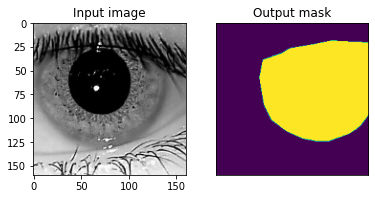

In [7]:
img, mask = test_dataset[2]
img = transforms.ToPILImage()(img)
mask = transforms.ToPILImage()(mask)
plot_img_and_mask(img, mask)

# Model

In [8]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('Linear') != -1:
    init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def weights_init_xavier(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.xavier_normal_(m.weight.data, gain=1)
  elif classname.find('Linear') != -1:
    init.xavier_normal_(m.weight.data, gain=1)
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def weights_init_kaiming(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
  elif classname.find('Linear') != -1:
    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def weights_init_orthogonal(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.orthogonal_(m.weight.data, gain=1)
  elif classname.find('Linear') != -1:
    init.orthogonal_(m.weight.data, gain=1)
  elif classname.find('BatchNorm') != -1:
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
  #print('initialization method [%s]' % init_type)
  if init_type == 'normal':
    net.apply(weights_init_normal)
  elif init_type == 'xavier': #he uniform
    net.apply(weights_init_xavier)
  elif init_type == 'kaiming':
    net.apply(weights_init_kaiming)
  elif init_type == 'orthogonal':
    net.apply(weights_init_orthogonal)
  else:
    raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [9]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)
    
class unetUp_origin(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp_origin, self).__init__()
        # self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale
        #
        # filters = [32, 64, 128, 256, 512]
        filters = [64, 128, 256, 512, 1024]
        # # filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)
        #
        self.outconv1 = nn.Conv2d(filters[0], 1, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def dotProduct(self,seg,cls):
        B, N, H, W = seg.size()
        seg = seg.view(B, N, H * W)
        final = torch.einsum("ijk,ij->ijk", [seg, cls])
        final = final.view(B, N, H, W)
        return final

    def forward(self, inputs):
        conv1 = self.conv1(inputs)  # 16*512*1024
        maxpool1 = self.maxpool1(conv1)  # 16*256*512

        conv2 = self.conv2(maxpool1)  # 32*256*512
        maxpool2 = self.maxpool2(conv2)  # 32*128*256

        conv3 = self.conv3(maxpool2)  # 64*128*256
        maxpool3 = self.maxpool3(conv3)  # 64*64*128

        conv4 = self.conv4(maxpool3)  # 128*64*128
        maxpool4 = self.maxpool4(conv4)  # 128*32*64

        center = self.center(maxpool4)  # 256*32*64

        up4 = self.up_concat4(center, conv4)  # 128*64*128
        up3 = self.up_concat3(up4, conv3)  # 64*128*256
        up2 = self.up_concat2(up3, conv2)  # 32*256*512
        up1 = self.up_concat1(up2, conv1)  # 16*512*1024

        d1 = self.outconv1(up1)  # 256

        return F.sigmoid(d1)

In [11]:
class UNet_3Plus(nn.Module):
  def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
    super(UNet_3Plus, self).__init__()
    self.is_deconv = is_deconv
    self.in_channels = in_channels
    self.is_batchnorm = is_batchnorm
    self.feature_scale = feature_scale

    filters = [64, 128, 256, 512, 1024]

    ## -------------Encoder--------------
    self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

    ## -------------Decoder--------------
    self.CatChannels = filters[0]
    self.CatBlocks = 5
    self.UpChannels = self.CatChannels * self.CatBlocks

    '''stage 4d'''
    # h1->320*320, hd4->40*40, Pooling 8 times
    self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
    self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

    # h2->160*160, hd4->40*40, Pooling 4 times
    self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
    self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

    # h3->80*80, hd4->40*40, Pooling 2 times
    self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
    self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

    # h4->40*40, hd4->40*40, Concatenation
    self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
    self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd4->40*40, Upsample 2 times
    self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
    self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu4d_1 = nn.ReLU(inplace=True)

    '''stage 3d'''
    # h1->320*320, hd3->80*80, Pooling 4 times
    self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
    self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

    # h2->160*160, hd3->80*80, Pooling 2 times
    self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

    # h3->80*80, hd3->80*80, Concatenation
    self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
    self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

    # hd4->40*40, hd4->80*80, Upsample 2 times
    self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd4->80*80, Upsample 4 times
    self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
    self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
    self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu3d_1 = nn.ReLU(inplace=True)

    '''stage 2d '''
    # h1->320*320, hd2->160*160, Pooling 2 times
    self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
    self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

    # h2->160*160, hd2->160*160, Concatenation
    self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
    self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

    # hd3->80*80, hd2->160*160, Upsample 2 times
    self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

    # hd4->40*40, hd2->160*160, Upsample 4 times
    self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
    self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd2->160*160, Upsample 8 times
    self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
    self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

    # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
    self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu2d_1 = nn.ReLU(inplace=True)

    '''stage 1d'''
    # h1->320*320, hd1->320*320, Concatenation
    self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
    self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

    # hd2->160*160, hd1->320*320, Upsample 2 times
    self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
    self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd3->80*80, hd1->320*320, Upsample 4 times
    self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
    self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd4->40*40, hd1->320*320, Upsample 8 times
    self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
    self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
    self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

    # hd5->20*20, hd1->320*320, Upsample 16 times
    self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
    self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
    self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
    self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

    # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
    self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
    self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
    self.relu1d_1 = nn.ReLU(inplace=True)

    # output
    self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

    # initialise weights
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        init_weights(m, init_type='kaiming')
      elif isinstance(m, nn.BatchNorm2d):
        init_weights(m, init_type='kaiming')

  def forward(self, inputs):
    ## -------------Encoder-------------
    h1 = self.conv1(inputs)  # h1->320*320*64

    h2 = self.maxpool1(h1)
    h2 = self.conv2(h2)  # h2->160*160*128

    h3 = self.maxpool2(h2)
    h3 = self.conv3(h3)  # h3->80*80*256

    h4 = self.maxpool3(h3)
    h4 = self.conv4(h4)  # h4->40*40*512

    h5 = self.maxpool4(h4)
    hd5 = self.conv5(h5)  # h5->20*20*1024

    ## -------------Decoder-------------
    h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
    h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
    h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
    h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
    hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
    hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
        torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

    h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
    h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
    h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
    hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
    hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
    hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
        torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

    h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
    h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
    hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
    hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
    hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
    hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
        torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

    h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
    hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
    hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
    hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
    hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
    hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
        torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

    d1 = self.outconv1(hd1)  # d1->320*320*n_classes
    return F.sigmoid(d1)

# Train

In [12]:
from torch.autograd import Function

class DiceCoeff(Function):
  def forward(self, input, target):
    self.save_for_backward(input, target)
    eps = 0.0001
    self.inter = torch.dot(input.view(-1), target.view(-1))
    self.union = torch.sum(input) + torch.sum(target) + eps

    t = (2 * self.inter.float() + eps) / self.union.float()
    return t

  # This function has only a single output, so it gets only one gradient
  def backward(self, grad_output):
    input, target = self.saved_variables
    grad_input = grad_target = None

    if self.needs_input_grad[0]:
      grad_input = grad_output * 2 * (target * self.union - self.inter) \
                    / (self.union * self.union)
    if self.needs_input_grad[1]:
      grad_target = None

    return grad_input, grad_target

def dice_coeff(input, target):
  """Dice coeff for batches"""
  if input.is_cuda:
    s = torch.FloatTensor(1).cuda().zero_()
  else:
    s = torch.FloatTensor(1).zero_()

  for i, c in enumerate(zip(input, target)):
    s = s + DiceCoeff().forward(c[0], c[1])

  return s / (i + 1)

In [13]:
def eval_net(net, loader, device):
  net.eval()
  n_val = len(loader)
  tot = 0

  for i, data in enumerate(loader):
    imgs, true_masks = data
    imgs = imgs.to(device=device)
    true_masks = true_masks.to(device=device)

    with torch.no_grad():
      mask_pred = net(imgs)

    pred = torch.sigmoid(mask_pred)
    # pred = (pred > 0.5).float()
    tot += dice_coeff(pred, true_masks).item()
    
  net.train()
  return tot / n_val

In [14]:
def train_net(net, train_loader, test_loader, criterion, optim, epochs=5):
  train_loader_len = len(train_loader)
  print_every = math.floor(train_loader_len / 3)
  net_loss = []
  net_eval = []

  for epoch in range(epochs):
    net.train()
    epoch_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_loader):
      image, true_mask = data
      image = image.to(device)
      true_mask = true_mask.to(device)
      mask_pred = net(image)
      
      optim.zero_grad()
      loss = criterion(mask_pred, true_mask)
      epoch_loss += loss.item()

      loss.backward()
      # nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optim.step()

      if i%print_every == 0:
        print('[batch: {}/{}] Current loss: {:.3f}'.format(i, train_loader_len, loss.item()))

    exec_time = time.time() - start_time
    epoch += 1
    net_loss.append(epoch_loss)
    val_score = eval_net(net, test_loader, device)
    net_eval.append(val_score)
    print('Epoch: {}/{} Loss: {:.3f} In: {:.3f}s'.format(epoch, epochs, epoch_loss, exec_time))

  print('Finished Training')
  return net_loss, net_eval

In [15]:
# #Tain UNet
# weight_dir = 'drive/My Drive/datasets/iris_segmentation/unet_carvana.pth'
# unet = UNet().to(device)

# checkpoint = torch.load(weight_dir)
# unet3.load_state_dict(checkpoint.state_dict())

# unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1).to(device)

# lr = 0.00001
# optim = torch.optim.Adam(unet.parameters(), betas = [0.5, 0.999], lr=lr)
# criterion = nn.BCEWithLogitsLoss() # UNet original paper loss

# unet_loss = []
# unet_eval = []

# unet_loss, unet_eval = train_net(unet, train_loader, test_loader, criterion, optim, epochs=10)

In [16]:
# x = np.arange(1, 11)
# fig, ax = plt.subplots()
# ax.plot(x, unet_loss, label='Loss')
# ax.plot(x, unet_eval, label='Evaluation')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('')
# ax.legend()

In [ ]:
#Trin UNet3+
weight_dir = 'drive/My Drive/datasets/iris_segmentation/unet3+.pth'
unet3 = UNet_3Plus().to(device)

# checkpoint = torch.load(weight_dir)
# unet3.load_state_dict(checkpoint.state_dict())

lr = 0.00001
momentum = 0.6
epochs = 20
# criterion = nn.BCEWithLogitsLoss() # UNet original paper loss
criterion = FocalLoss(alpha=2, gamma=4) # UNet3+ original paper loss

# optim = torch.optim.Adam(unet3.parameters(), betas = [0.05, 0.999], lr=lr) # UNet original paper loss
optim = torch.optim.SGD(unet3.parameters(), lr=lr, momentum=momentum) # UNet3 original paper loss

unet3_loss = []
unet3_eval = []

unet3_loss, unet3_eval = train_net(unet3, train_loader, test_loader, criterion, optim, epochs=epochs)
torch.save(unet3, weight_dir)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[batch: 0/119] Current loss: 0.294
[batch: 39/119] Current loss: 0.226
[batch: 78/119] Current loss: 0.182
[batch: 117/119] Current loss: 0.196
Epoch: 1/20 Loss: 25.862 In: 77.283s
[batch: 0/119] Current loss: 0.193
[batch: 39/119] Current loss: 0.189
[batch: 78/119] Current loss: 0.173
[batch: 117/119] Current loss: 0.167
Epoch: 2/20 Loss: 20.438 In: 77.316s
[batch: 0/119] Current loss: 0.175
[batch: 39/119] Current loss: 0.144
[batch: 78/119] Current loss: 0.152
[batch: 117/119] Current loss: 0.148
Epoch: 3/20 Loss: 17.927 In: 77.295s
[batch: 0/119] Current loss: 0.136
[batch: 39/119] Current loss: 0.145
[batch: 78/119] Current loss: 0.142
[batch: 117/119] Current loss: 0.152
Epoch: 4/20 Loss: 16.541 In: 77.316s
[batch: 0/119] Current loss: 0.130
[batch: 39/119] Current loss: 0.139
[batch: 78/119] Current loss: 0.140
[batch: 117/119] Current loss: 0.128
Epoch: 5/20 Loss: 15.609 In: 77.310s
[batch: 0/119] Current loss: 0.132
[batch: 39/119] Current loss: 0.121
[batch: 78/119] Current 

In [ ]:
x = np.arange(1, epochs+1)
fig, ax = plt.subplots()
ax.plot(x, unet3_loss, label='Loss')
ax.plot(x, unet3_eval, label='Evaluation')
ax.set_xlabel('Epochs')
ax.set_ylabel('')
ax.legend()

In [ ]:
def predict_img(net, full_img, device, out_threshold=0.5):
  net.eval()

  img = torch.from_numpy(full_img)
  img = img.unsqueeze(0)
  # img = full_img.unsqueeze(0)
  img = img.to(device=device, dtype=torch.float32)
  print(img.shape)

  with torch.no_grad():
    output = net(img)

    probs = torch.sigmoid(output)
    probs = probs.squeeze(0)

    tf = transforms.Compose([
      transforms.ToPILImage(),
      transforms.ToTensor(),
      transforms.CenterCrop(240),
      transforms.Resize((160, 160)),
    ])

    probs = tf(probs.cpu())
    full_mask = probs.squeeze().cpu().numpy()

  return full_mask > out_threshold

In [ ]:
# dir = 'drive/My Drive/Undecimo Semestre/Vision Computacional/datasets/IITD/{folder}/01_L.bmp'
# dir = 'drive/My Drive/Undecimo Semestre/Vision Computacional/datasets/Ubiris2/iris/{file}.tiff'
dir = 'drive/My Drive/datasets/IITD/{folder}/01_L.bmp'
# dir = 'drive/My Drive/datasets/Ubiris2/iris/{file}.tiff'

In [ ]:
# # Unet test
# for i in range(10):
#   dir_acc = dir.replace("{folder}", str(200+i))
#   # next_file = 'C'+str(1+i)+'_S'+str(1+i)+'_I1'
#   # dir_acc = dir.replace("{file}", next_file)
#   pil_img = Image.open(dir_acc).resize((320,240))
#   img = np.array(pil_img).transpose((2, 0, 1))
#   mask = predict_img(net=unet, full_img=img, device=device, out_threshold=0.5)
#   plot_img_and_mask(pil_img, mask)

In [ ]:
# Unet3+ test
# unet3 = UNet_3Plus().to(device)
for i in range(10):
  dir_acc = dir.replace("{folder}", str(200+i))
  pil_img = Image.open(dir_acc)
  # next_file = 'C'+str(1+i)+'_S'+str(1+i)+'_I1'
  # dir_acc = dir.replace("{file}", next_file)
  # pil_img = Image.open(dir_acc).resize((320,240))
  img = np.array(pil_img).transpose((2, 0, 1))
  mask = predict_img(net=unet3, full_img=img, device=device, out_threshold=0.5)
  plot_img_and_mask(pil_img, mask)

In [ ]:
# x = np.arange(1, 6)
# fig, ax = plt.subplots()
# # ax.plot(x, unet_loss_bce, label='UNet BCEWithLogitsLoss')
# # ax.plot(x, unet3_loss_bce, label='UNet3+ BCEWithLogitsLoss')
# ax.plot(x, unet_loss, label='UNet FocalLoss')
# ax.plot(x, unet3_loss, label='UNet3+ FocalLoss')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Loss')
# ax.legend()